In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

df = pd.read_csv("chaos_data.csv")

df

,Squad,League,Poss,PrgC,PrgP,Ps PrgDist,Ps Cmp,Ps Cmp%,Opp Ps Cmp%,Short Att,...,PPDA,OPPDA,xT,xTA,DLINE,ODLINE,BUILD,OBUILD,LOS,OLOS
0,Arsenal,Premier League,56.1,686,1487,70741,13583,83.8,80.0,7521,...,8.54,14.31,1.67,0.97,51.43,39.76,86.30,79.89,15.14,28.10
1,Aston Villa,Premier League,51.2,592,1078,72056,12206,82.8,82.8,6235,...,12.04,9.79,1.38,1.31,45.06,46.42,85.80,85.16,24.48,19.03
2,Bournemouth,Premier League,47.5,619,1222,71266,10303,76.0,77.9,5174,...,8.48,9.37,1.49,1.54,46.89,42.95,77.56,78.88,23.10,30.66
3,Brentford,Premier League,48.1,495,1127,77468,11103,78.2,80.3,5655,...,10.90,11.91,1.45,1.56,45.19,46.48,81.69,81.37,24.14,24.83
4,Brighton,Premier League,52.3,654,1249,74972,12837,82.3,80.3,6801,...,9.73,12.15,1.38,1.24,47.31,42.87,85.09,81.85,20.83,26.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Reims,Ligue 1,44.2,504,1009,64927,9871,79.6,83.6,5037,...,13.85,9.61,1.21,1.59,43.02,48.04,81.78,85.76,24.59,19.96
92,Rennes,Ligue 1,50.9,545,1203,70082,11479,81.8,80.7,5688,...,10.14,11.39,1.31,1.24,47.41,44.34,84.02,81.93,25.41,26.15
93,Saint-Étienne,Ligue 1,45.9,433,937,62792,10275,80.9,83.6,5572,...,13.68,10.34,1.11,1.62,43.08,47.66,82.33,85.42,27.35,21.96
94,Strasbourg,Ligue 1,49.9,454,977,72197,11845,83.6,82.1,5633,...,14.30,11.75,1.18,1.46,45.82,48.06,86.03,85.29,27.78,20.85


In [4]:
features = df.drop(["Squad", "League"], axis=1)
team_names = df["Squad"]

for column in features.columns:
    if features[column].dtype == 'object':
        # Try to convert strings with commas to float
        features[column] = features[column].replace({',': ''}, regex=True)
        features[column] = pd.to_numeric(features[column], errors='coerce')

# Drop any rows with NaN values that might have been introduced
features = features.dropna()
# Keep only the corresponding team names
team_names = team_names.loc[features.index]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [5]:
pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(
    data=principal_components, 
    columns=['PC1', 'PC2']
)
pca_df['Squad'] = team_names.values

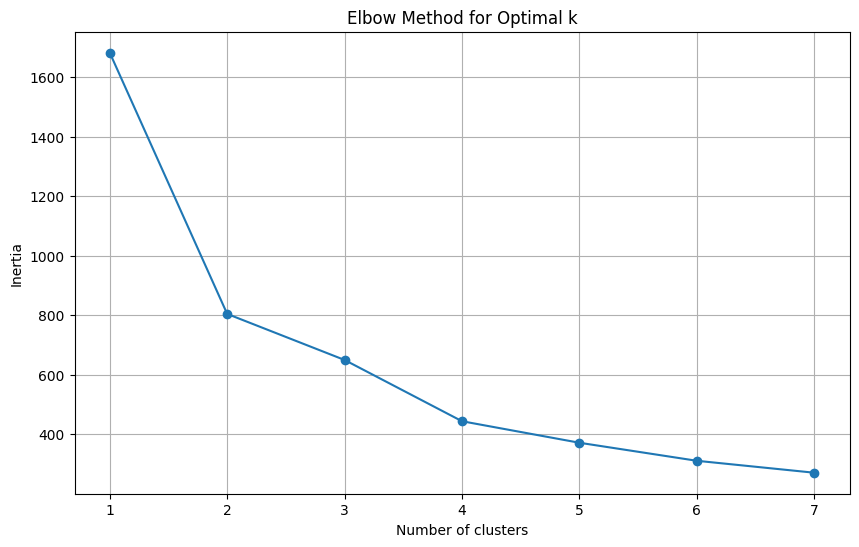

In [6]:
inertia = []
k_range = range(1, 8)  # Testing 1-7 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(principal_components)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

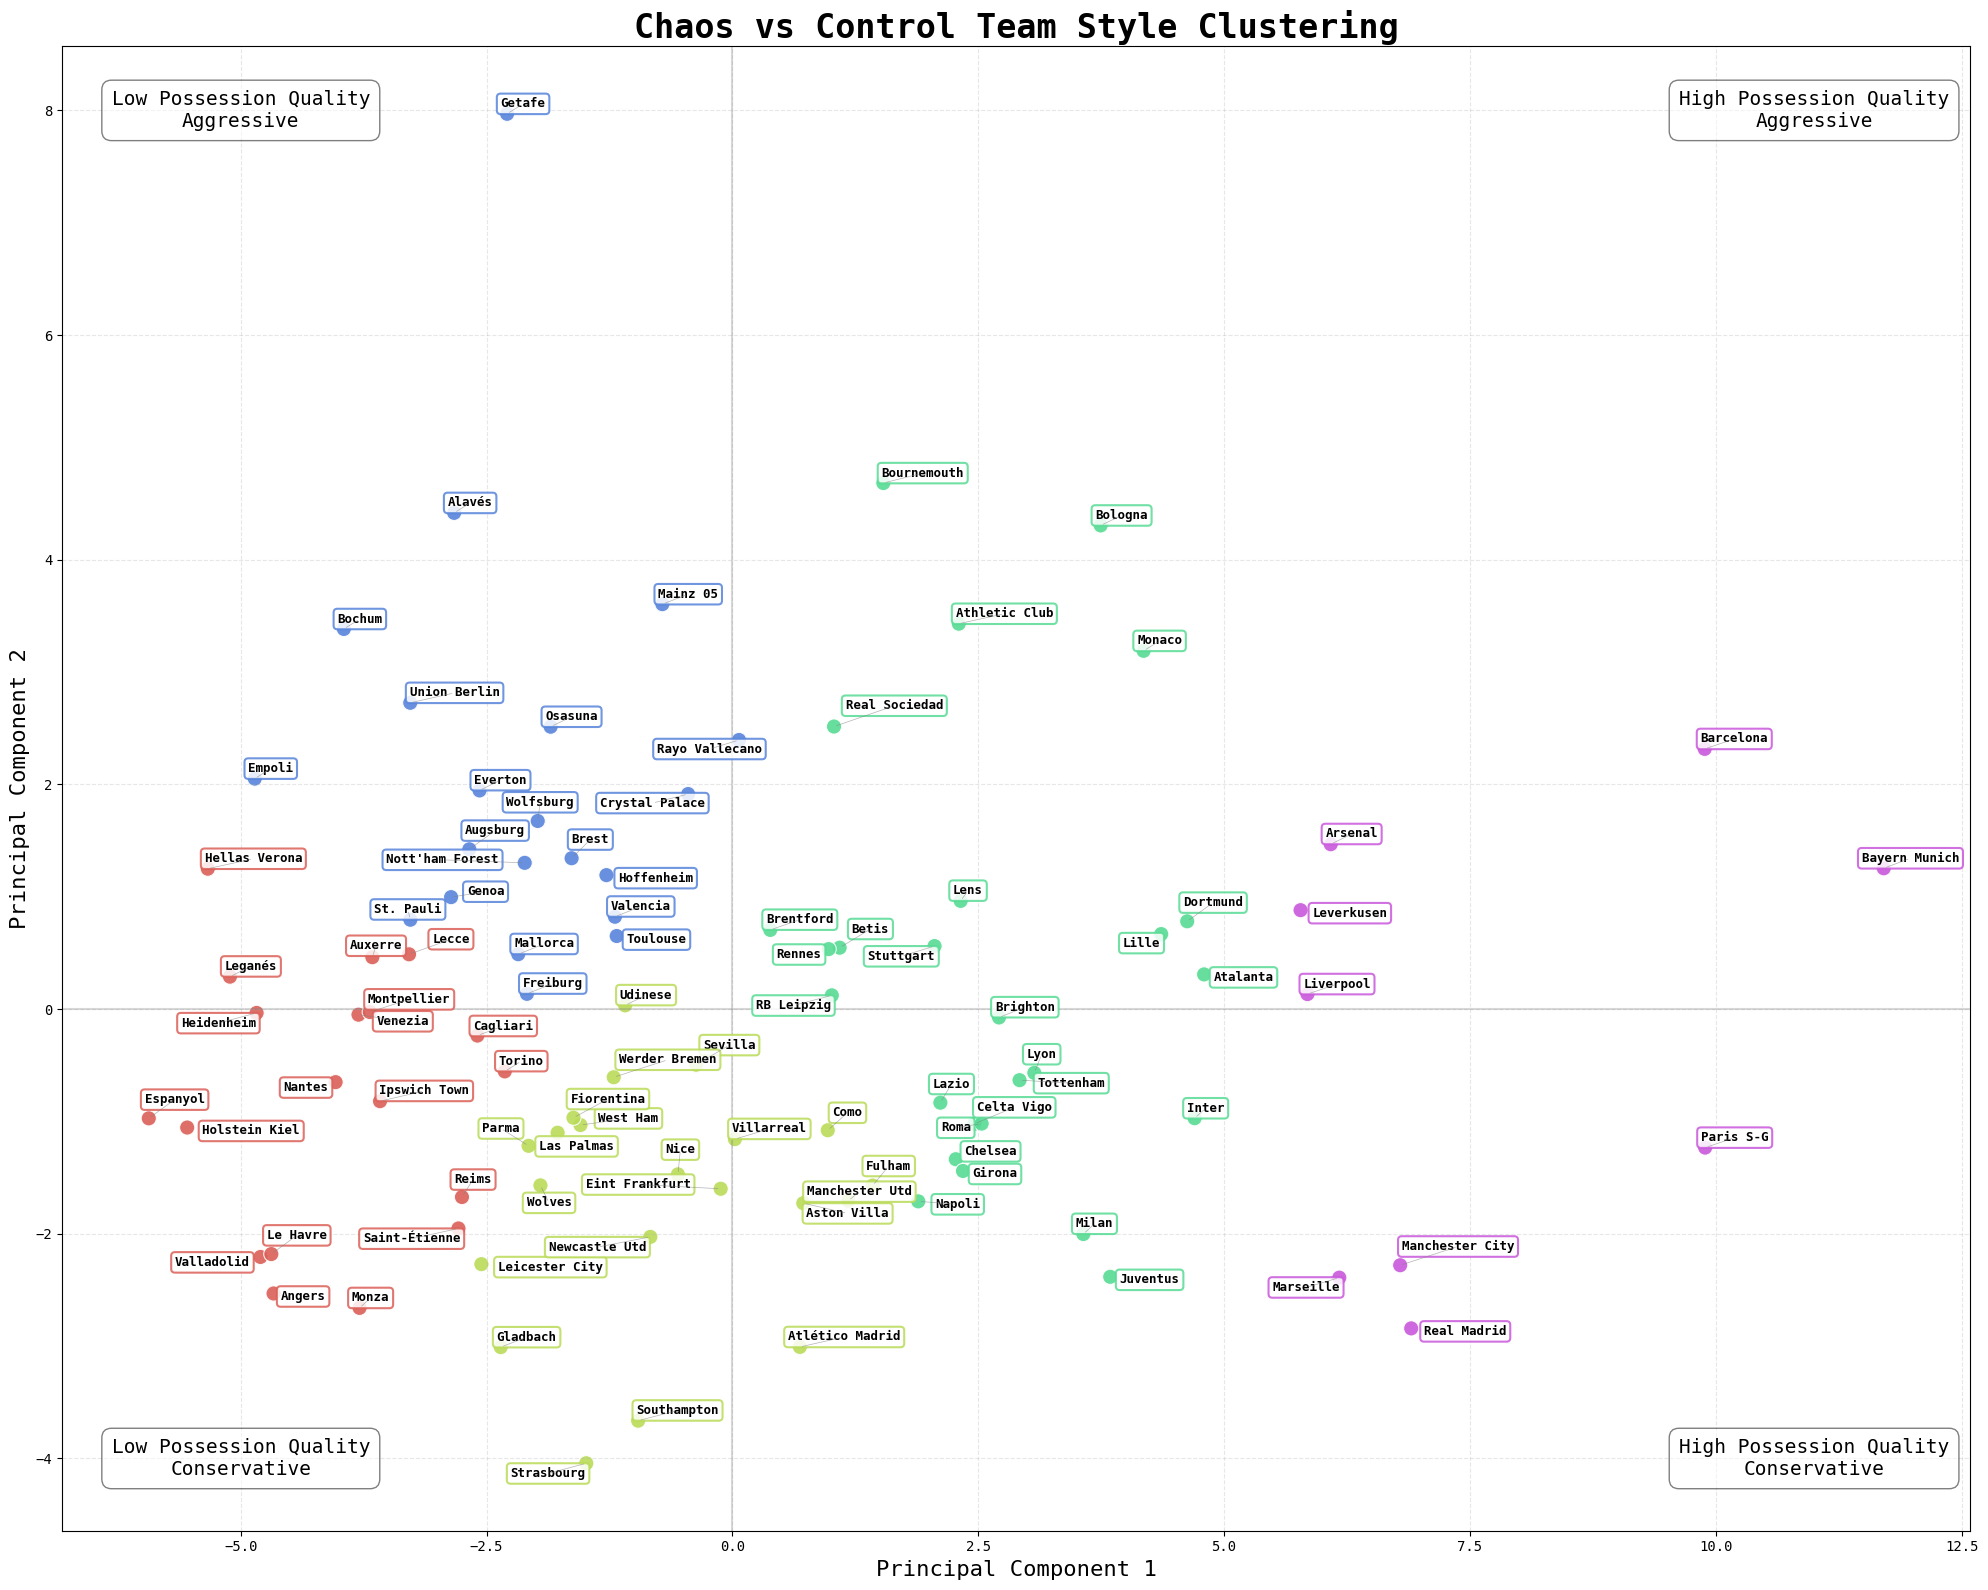

In [37]:
from adjustText import adjust_text

# Set the global font to monospace
plt.rcParams['font.family'] = 'monospace'

# Assuming principal_components, pca_df, and clusters are already defined

optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=50)
clusters = kmeans.fit_predict(principal_components)

# Add the cluster labels to our dataframe
pca_df['Cluster'] = clusters

# Step 6: Visualization
plt.figure(figsize=(20, 16))

# Create the scatter plot
scatter = sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    palette=sns.color_palette("hls", len(pca_df['Cluster'].unique())),
    data=pca_df,
    s=120,
    alpha=0.9,
    edgecolor='white',
    linewidth=0.8
)

# Get colors for labels
cluster_colors = sns.color_palette("hls", len(pca_df['Cluster'].unique()))

# Create text objects list for adjust_text - with monospace font
texts = []
for i, row in pca_df.iterrows():
    texts.append(plt.text(
        row['PC1'], row['PC2'], row['Squad'],
        color='black',
        fontsize=9,
        weight='bold',
        family='monospace',  # Ensure monospace for team labels
        ha='center',
        bbox=dict(
            boxstyle="round,pad=0.3",
            fc='white',
            ec=cluster_colors[row['Cluster']],
            alpha=0.85,
            linewidth=1.5
        )
    ))

# Use adjust_text with more aggressive settings
# Increase iterations and force for better separation
adjust_text(
    texts,
    expand_points=(1.5, 1.5),
    force_points=(0.5, 0.8),
    force_text=(0.8, 0.8),
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.6),
    autoalign='xy',
    only_move={'points':'xy', 'text':'xy'},
    lim=300
)

# Improve grid and overall appearance
plt.grid(True, linestyle='--', alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)

# Add titles with more detailed information - with larger font and monospace
plt.title('Chaos vs Control Team Style Clustering', 
          fontsize=24,  # Increased from 18 to 24
          family='monospace', 
          weight='bold')

plt.xlabel(f'Principal Component 1', 
           fontsize=16, 
           family='monospace')
           
plt.ylabel(f'Principal Component 2', 
           fontsize=16, 
           family='monospace')

# # Add a clearer legend with better formatting - with monospace font
# legend = plt.legend(
#     title='Clusters', 
#     title_fontsize=14, 
#     fontsize=12,
#     loc='upper right',
#     frameon=True,
#     framealpha=0.95,
#     edgecolor='gray'
# )
# # Set legend font to monospace
# plt.setp(legend.get_texts(), family='monospace')
# plt.setp(legend.get_title(), family='monospace')
scatter.get_legend().remove()

# Add quadrant labels with monospace font
plt.text(11, 8, "High Possession Quality\nAggressive", 
         fontsize=14, ha='center', va='center', family='monospace',
         bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

plt.text(-5, 8, "Low Possession Quality\nAggressive", 
         fontsize=14, ha='center', va='center', family='monospace',
         bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

plt.text(11, -4, "High Possession Quality\nConservative", 
         fontsize=14, ha='center', va='center', family='monospace',
         bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

plt.text(-5, -4, "Low Possession Quality\nConservative", 
         fontsize=14, ha='center', va='center', family='monospace',
         bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.savefig('pca_clusters_improved_mono.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
pca_components = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=features.columns
)
print("Principal Component Loadings:")
print(pca_components)

Principal Component Loadings:
                   PC1       PC2
Poss          0.257582 -0.068569
PrgC          0.224334 -0.147177
PrgP          0.264925 -0.031375
Ps PrgDist    0.240609 -0.077728
Ps Cmp        0.250022 -0.168529
Ps Cmp%       0.220134 -0.275226
Opp Ps Cmp%  -0.146377 -0.299425
Short Att     0.247213 -0.156306
Long Att     -0.057349  0.240369
Ps Opp 1/3    0.262462 -0.016433
% Ps Opp 1/3  0.089687  0.346206
Tkons Att     0.150132 -0.039006
Tou Def 3rd  -0.021950 -0.304327
Tou Att 3rd   0.229594  0.054615
Aer Total    -0.133092  0.219860
Recov         0.118362  0.077090
PPDA         -0.189376 -0.173887
OPPDA         0.217450 -0.121789
xT            0.230344  0.085747
xTA          -0.227631 -0.072942
DLINE         0.217997  0.175813
ODLINE       -0.213730 -0.160997
BUILD         0.210837 -0.237606
OBUILD       -0.154300 -0.323290
LOS          -0.112039 -0.132000
OLOS          0.109640  0.355101
